In [88]:
!pip install pandas networkx matplotlib

In [94]:
import pandas as pd
import networkx as nx
import re
from itertools import islice
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# sentiments_raw = pd.read_csv('edge_sentiments.txt', header=None)

In [3]:
# def preprocess_sentiment(sentiment):
#     sentiment = sentiment[len("Sentiment: "):].strip()
#     return 1 if sentiment == "non-burst" else -1

# sentiments = pd.DataFrame(columns=["source_post", "dest_post", "sentiment"])
# sentiments.iloc[:, 0] = sentiments_raw.iloc[:, 0].apply(lambda val: val[len("From Post: "):].strip())
# sentiments.iloc[:, 1] = sentiments_raw.iloc[:, 1].apply(lambda val: val[len("To Post: "):].strip())
# sentiments[sentiments.columns[2]] = sentiments_raw.iloc[:, 2].apply(preprocess_sentiment)
# print(sentiments.head())
# # Create a directed graph with sentiment as an edge attribute
# posts_graph = nx.from_pandas_edgelist(sentiments, 'source_post', 'dest_post', create_using=nx.DiGraph, edge_attr='sentiment')

# # Check if the edge "1u4nrp" -> "1u4lo2" exists in the graph
# src = "1u4nrp"
# dst = "1u4lo2"
# if posts_graph.has_edge(src, dst):
#     print(f"The edge '{src}' -> '{dst}' exists with sentiment: {posts_graph[src][dst]['sentiment']}")
# else:
#     print(f"The edge '{src}' -> '{dst}' does not exist in the graph.")

In [4]:
def create_dataframe_from_file(file_name):
    # Read the file and split lines
    with open(file_name, 'r') as file:
        lines = file.readlines()

    # Extract data and create a DataFrame
    rows = [line.replace("\t", " ").replace('"', '').replace(',','').replace("'", '').replace(")", '').replace("(", '').replace('\n', '').split(" ") for line in lines]
    df = pd.DataFrame(rows, columns=['source_post', 'dest_post', 'sentiment'])

    # Convert sentiment to integer
    df['sentiment'] = df['sentiment'].map({'non-burst': 1, 'burst': -1})

    return df

In [5]:
sentiments_raw = create_dataframe_from_file('label_info.tsv')
print(sentiments_raw.head())
print(sentiments_raw.iloc[20])

  source_post dest_post  sentiment
0      2vjbm2    2m13kx          1
1      3zagiy    2uf8t2          1
2      5yoid6    4i76wl          1
3      39rq01    3b41ta          1
4      4jp1x6    4jlea9          1
source_post    3ihytj
dest_post      3ih2o6
sentiment          -1
Name: 20, dtype: object


In [33]:
posts_graph = nx.from_pandas_edgelist(sentiments_raw, 'source_post', 'dest_post', create_using=nx.DiGraph, edge_attr='sentiment')

# posts_graph = nx.DiGraph()
# posts_graph.add_edges_from(sentiments_raw[['source_post', 'dest_post']].values, sentiment=sentiments_raw['sentiment'].to_dict())

In [7]:
def get_sentiment(dataframe, source_post_id, dest_post_id):
    try:
        result = dataframe[(dataframe['source_post'] == source_post_id) & (dataframe['dest_post'] == dest_post_id)]['sentiment'].values[0]
        return result
    except IndexError:
        return None

In [8]:
def create_graph_from_file(file_name):
    # Read the text file into a DataFrame, skipping the first four rows
    df = pd.read_csv(file_name, skiprows=4, delimiter='\t', header=None)

    # Create column names "source" and "dest"
    df.columns = ["source_subreddit", "dest_subreddit"]

    # Create a directed graph from the DataFrame
    G = nx.from_pandas_edgelist(df, 'source_subreddit', 'dest_subreddit', create_using=nx.DiGraph)
    return G

In [9]:
yearly_graphs = {}
for year in [2014, 2015, 2016, 2017]:
    yearly_graphs[year] = create_graph_from_file(f"pruned_graph_{year}.txt")

In [40]:
# Update edge attributes in the graph based on 'sentiments'
for edge in graph.edges:
    source, dest = edge

    # Check if the edge exists in the 'sentiments' DataFrame
    mask = (sentiments['source'] == source) & (sentiments['dest'] == dest)
    if not sentiments[mask].empty:
        # Edge exists, update the 'sentiment' attribute
        sentiment = sentiments.loc[mask, 'sentiment'].values[0]
        graph[source][dest]['sentiment'] = sentiment
    else:
        # Edge doesn't exist in the DataFrame, raise an error or handle it as needed
        raise ValueError(f"Edge ({source}, {dest}) doesn't exist in the 'sentiments' DataFrame!")

# Now 'graph' has updated 'sentiment' attributes for existing edges in 'sentiments'

ValueError: Edge (1212297454, 1026390623) doesn't exist in the 'sentiments' DataFrame!

In [123]:
def read_data(file_path):
    return pd.read_csv(file_path, parse_dates=[3, 7], sep=' ')

def create_graph(df):
    G = nx.MultiDiGraph()
    for index, row in df.iterrows():
        G.add_edge(row['source_subreddit'], row['dest_subreddit'],
                   source_post_id=row['source_post_id'],
                   dest_post_id=row['dest_post_id'], sentiment=row['sentiment'])
    return G

def process_and_save_overall_graph(file_path):
    df = read_data(file_path)
    
    graph = nx.DiGraph()
    for index, row in df.iterrows():
        source_subreddit = row['source_subreddit']
        dest_subreddit = row['dest_subreddit']
        if not graph.has_edge(source_subreddit, dest_subreddit):
            graph.add_edge(source_subreddit, dest_subreddit)
                           
    df.to_csv("overall_graph_across_years.csv", index=False)
    return graph

def process_and_save_graphs_by_year(file_path):
    df = read_data(file_path)
    
    # Iterate over unique years in the data
    df['source_post_date'] = pd.to_datetime(df['source_post_date'])

    # Create a dictionary to store graphs for each year
    graphs_by_year = {}

    for year in df['source_post_date'].dt.year.unique():
        # Filter DataFrame for the current year
        year_df = df[df['source_post_date'].dt.year == year]

        # Create a graph
        G = create_graph(year_df)

        # Store the graph in the dictionary
        graphs_by_year[year] = G

        # Save the DataFrame to a CSV file
        year_df.to_csv(f'subreddit_graph_{year}.csv', index=False)

    return graphs_by_year

def print_edge_attributes(graph, source_subreddit, dest_subreddit):
    # Check if there's at least one edge between the source and destination nodes
    if graph.has_edge(source_subreddit, dest_subreddit):
        # Get all edges between the source and destination nodes
        edges = graph.out_edges(source_subreddit, dest_subreddit, keys=True)

        # Print edge attributes
        for edge in edges:
            edge_data = graph[edge[0]][edge[1]][edge[2]]  # Get the entire edge data dictionary
            print(f"Edge: {source_subreddit} -> {dest_subreddit}")
            print(f"  Edge Data: {edge_data}")
    else:
        print(f"No edge found between {source_subreddit} and {dest_subreddit}")


In [50]:
def add_sentiment_column(file_path, save_path, posts_graph):
    # add sentiment data to file
    data_without_sentiment = pd.read_csv(file_path, parse_dates=[3, 7], sep=' ', header=None,
                                         names=["source_subreddit", "dest_subreddit", "source_post_id",
                                                "source_post_date", "source_post_time", "user",
                                                "dest_post_id", "dest_post_date", "dest_post_time"])

    sentiments = []  # List to store sentiments

    print("starting")
    firsttime = True
    # Use tqdm to visualize the progress
    for index, row in tqdm(data_without_sentiment.iterrows(), total=len(data_without_sentiment), desc="Processing rows"):
        if firsttime:
            print("started")
        
        source_post_id = row["source_post_id"]
        dest_post_id = row["dest_post_id"]
        try:
            sentiment = posts_graph[source_post_id][dest_post_id]['sentiment']
            if firsttime:
                print(sentiment)
            sentiments.append(sentiment)
        except KeyError:
            raise Exception(f"No edge found between {source_post_id} and {dest_post_id}")
        firsttime = False

    print("ended")
    # Add the 'sentiment' column to the DataFrame
    data_without_sentiment['sentiment'] = sentiments

    print("storing")
    # Save the DataFrame to a TSV file
    data_without_sentiment.to_csv(save_path, index=False, sep=' ')
    print("done")
    return data_without_sentiment

In [45]:
data_file = "formatted_data_file_with_sentimemnt.txt"
data_with_sentiment = add_sentiment_column("formatted_data_file.txt", data_file, posts_graph)

starting


Processing rows:   0%|             | 1326/286561 [00:01<03:47, 1256.34it/s]

started
1


Processing rows: 100%|██████████| 286561/286561 [00:23<00:00, 12404.42it/s]


ended
storing
done


In [40]:
print(data_with_sentiment.head())

  source_subreddit   dest_subreddit source_post_id source_post_date  \
0  leagueoflegends  teamredditteams         1u4nrp       2013-12-31   
1       theredlion           soccer         1u4qkd       2013-12-31   
2     inlandempire           bikela         1u4qlz       2013-12-31   
3              nfl              cfb         1u4sjv       2013-12-31   
4       playmygame          gamedev         1u4w5s       2013-12-31   

  source_post_time             user dest_post_id dest_post_date  \
0         16:39:37  Samwise_Gardner       1u4lo2     2013-12-31   
1         17:17:07  HarryBlessKnapp       1u4muc     2013-12-31   
2         17:17:41        morbetter       1u4pss     2013-12-31   
3         17:45:13      primeoflife       1u4mjo     2013-12-31   
4         18:38:21          dkramer       1u54ij     2013-12-31   

  dest_post_time  sentiment  
0       16:11:17          1  
1       16:27:11          1  
2       17:07:05          1  
3       16:22:57          1  
4       21:06:37    

In [54]:
graphs_by_year = process_and_save_graphs_by_year(data_file)

year: 2013
year: 2014
year: 2015
year: 2016
year: 2017


In [107]:
# print_edge_attributes(graphs_by_year[2014], "leagueoflegends", "teamredditteams")

In [132]:
def generate_sentiment_map(graph):
    sentiment_map = {}

    for source_subreddit, dest_subreddit, data in graph.edges(data=True):
        # Check if sentiment attribute exists
        if 'sentiment' in data:
            sentiment = data['sentiment']
            
            # Initialize sentiment counters if not present
            if source_subreddit not in sentiment_map:
                sentiment_map[source_subreddit] = {'positive': 0, 'negative': 0}

            # Update sentiment counters based on sentiment value
            if sentiment == 1:
                sentiment_map[source_subreddit]['positive'] += 1
            elif sentiment == -1:
                sentiment_map[source_subreddit]['negative'] += 1
        else:
            raise Exception(f"No sentiment found for edge {source_subreddit} -> {dest_subreddit}")

    return sentiment_map


def generate_importance_map(graph):
    pagerank_scores = nx.pagerank(graph)
    importance_map = {node: {'importance': score} for node, score in pagerank_scores.items()}
    return importance_map

In [139]:
sentiment_map = {}
sentiment_map[2014] = generate_sentiment_map(graphs_by_year[2014])
sentiment_map[2015] = generate_sentiment_map(graphs_by_year[2015])
sentiment_map[2016] = generate_sentiment_map(graphs_by_year[2016])
sentiment_map[2017] = generate_sentiment_map(graphs_by_year[2017])

importance_map = {}
importance_map[2014] = generate_importance_map(graphs_by_year[2014])
importance_map[2015] = generate_importance_map(graphs_by_year[2015])
importance_map[2016] = generate_importance_map(graphs_by_year[2016])
importance_map[2017] = generate_importance_map(graphs_by_year[2017])

In [65]:
def get_top_n_sentiment_keys(sentiment_map, n, sentiment_type, descending=True):
    sorted_keys = sorted(sentiment_map.keys(), key=lambda k: sentiment_map[k][sentiment_type], reverse=descending)
    return sorted_keys[:n]

In [163]:
def subreddit_plot_info_df(subreddits):
    df = pd.DataFrame(columns=["subreddit", "year", "negativity", "importance"])
    for year in [2014, 2015, 2016, 2017]:
        rows = []
        for subreddit in subreddits:
            if subreddit in sentiment_map[year]:
                negativity_value = sentiment_map[year][subreddit]['negative']
                importance_value = importance_map[year][subreddit]['importance']
                rows.append({"subreddit": subreddit, "year": int(year), "negativity": negativity_value, "importance": importance_value})

        df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
    return df
        
def plot_negativity(subreddits, subreddit_group_name):
    df = subreddit_plot_info_df(subreddits)
    plt.figure(figsize=(10, 6))
    plt.xlabel("Year")
    plt.ylabel("Negativity")
    plt.title(f"Negativity Trends for {subreddit_group_name}")

    df.set_index("year").groupby("subreddit").negativity.plot()
    plt.legend(title="Subreddit")
    plt.show()
    
def plot_importance(subreddits, subreddit_group_name):
    df = subreddit_plot_info_df(subreddits)
    plt.figure(figsize=(10, 6))
    plt.xlabel("Year")
    plt.ylabel("Importance")
    plt.title(f"Importance Trends for {subreddit_group_name}")

    df.set_index("year").groupby("subreddit").importance.plot()
    plt.legend(title="Subreddit")
    plt.show()

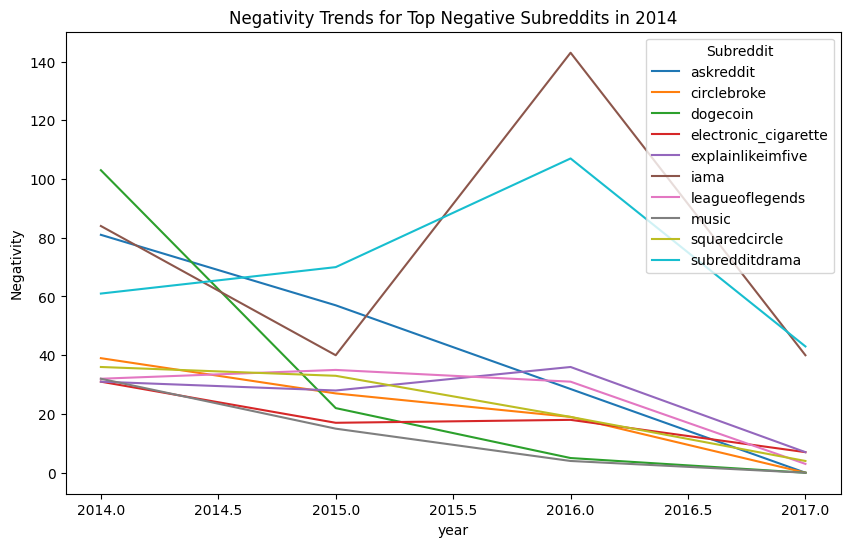

In [156]:
n = 10
top_negative_subreddits = get_top_n_sentiment_keys(sentiment_map_2014, n, 'negative')
plot_negativity(top_negative_subreddits, "Top Negative Subreddits in 2014")

In [157]:
overall_graph = process_and_save_overall_graph(data_file)

In [158]:
print(list(overall_graph.edges(data=True))[:5])

[('leagueoflegends', 'teamredditteams', {}), ('leagueoflegends', 'leagueoflegendsmeta', {}), ('leagueoflegends', 'iama', {}), ('leagueoflegends', 'whowouldwin', {}), ('leagueoflegends', 'lolchampconcepts', {})]


In [159]:
pagerank_scores = nx.pagerank(overall_graph)

In [160]:
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
top_important_subreddits = [item[0] for item in sorted_pagerank[:n]]

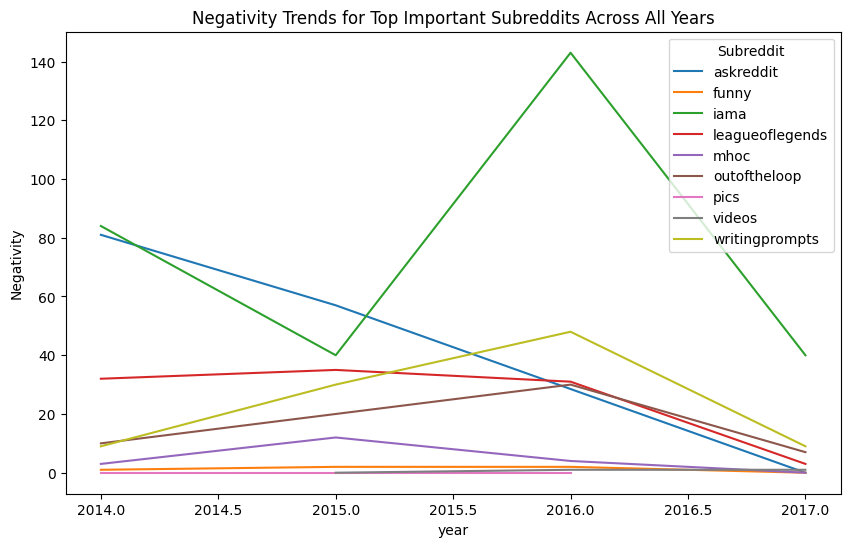

In [161]:
plot_negativity(top_important_subreddits, "Top Important Subreddits Across All Years")

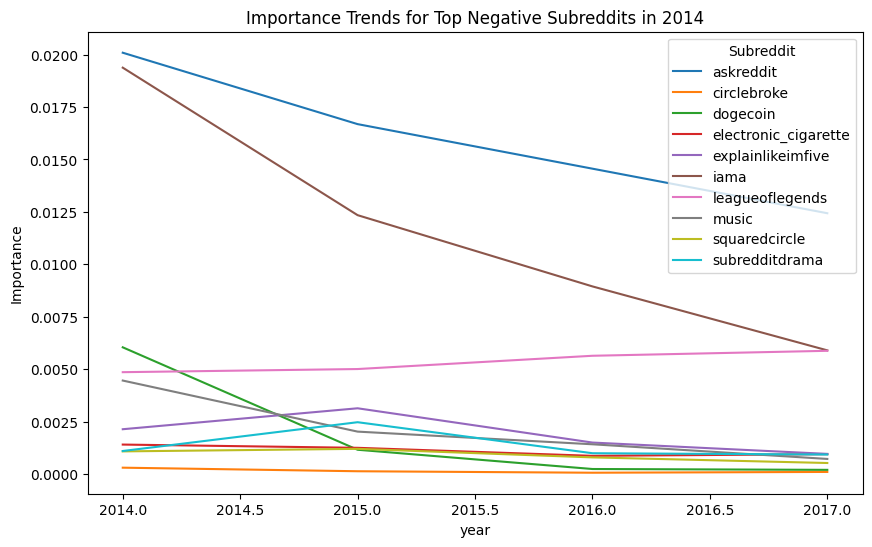

In [164]:
# importance across years of the top negative subreddits in 2014 - how was their importance affected by the negativity?
# print(top_important_subreddits)
# print([pagerank_scores[subreddit] for subreddit in top_important_subreddits])
plot_importance(top_negative_subreddits, "Top Negative Subreddits in 2014")